<a href="https://colab.research.google.com/github/NsSuraj-01/DeFi-app/blob/main/Sentiment_analysis_on_CMET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
print(tf.__version__)
import os

%matplotlib inline

2.15.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(0)

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Embedding, Dropout, SimpleRNN, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GRU, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from sklearn import metrics

In [ ]:
path_dataset = "/content/drive/MyDrive/Colab Notebooks/codemix_sentiment_data (1).txt"
norm_dataset = "/content/drive/MyDrive/Colab Notebooks/normalized_data (1).csv"

In [ ]:
#SymSpell is a Python library designed to perform efficient spelling correction and fuzzy string matching.
!pip install symspellpy
import pkg_resources
from symspellpy import SymSpell, Verbosity
import re


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.6/2.6 MB 14.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 98.5/98.5 kB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=187490 sha256=4d783bea6a36f10a2dc563ee7418b843edf24a21356ed9958d6f75efed00ddd6
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [ ]:
def elongation_normalization(text):
    text = text.lower()
    text = re.sub(r'(.)\1{2,}', r"\1\1", text)
    return text
example = "hellooo bagundhiii, gooood"
elongation_normalization(example)

'helloo bagundhii, good'

In [ ]:
#SymSpell is a Python library designed to perform efficient spelling correction and fuzzy string matching.
sym_spell = SymSpell(max_dictionary_edit_distance=4)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def eng_spelling_correction(text):
    result = sym_spell.word_segmentation(text)
    return result.corrected_string

example = "thsi isa a lovely movei"
eng_spelling_correction(example)

'this is a lovely movie'

In [ ]:
def transliteration_normalization(text):
    text = re.sub(r'(.)\1{1,}', r"\1", text)
    return text

example = "tinnaavaa sarigga"
transliteration_normalization(example)

'tinava sariga'

In [ ]:
def consonant_normalization(text):
    text = text.replace('kh', 'k')
    text = text.replace('chh', 'ch')
    text = text.replace('gh', 'g')
    text = text.replace('th', 't')
    text = text.replace('jh', 'j')
    text = text.replace('dh', 'd')
    text = text.replace('bh', 'b')
    return text
example = "thinnava jharkand"
consonant_normalization(example)

'tinnava jarkand'

In [ ]:
def data_normalization(text_tuple):
    text = ""
    for tupl in text_tuple:
        word = tupl[0]
        lang = tupl[1]

        word = elongation_normalization(word) # for both languages

        if lang == 'en': #english words
            word = eng_spelling_correction(word)
            text += word + " "

        if lang == 'te': # telugu words
            word = transliteration_normalization(word)
            word = consonant_normalization(word)
            text += word + " "

        if lang == 'univ': # universal
            text += word + " "
    return text

example = [('worstttt', 'en'), ('government', 'en'), ('.', 'univ'), ('#YSRCP', 'univ'), ('chala', 'te'), ('chethha', 'te'), ('ga', 'te'), ('paripalana', 'te'), ('chesthumdhi', 'te'), ('.', 'univ')]
data_normalization(example)

'worst government . #ysrcp chala cheta ga paripalana chestumdi . '

In [ ]:
# Reading the text data
with open(path_dataset) as f:
    df = f.readlines()

In [ ]:
len(df)

79471

In [ ]:
labels = []
sents = []
for i in range(0, len(df), 4):
    line1 = df[i]
    line2 = df[i+1]

    text = line1.replace('\n','')
    lang = line2.replace('\n','')

    label, sent = text[:3], text[4:]

    labels.append(label)
    out = [(word, lang) for word, lang in zip(sent.split(), lang.split())]
    sents.append(out)

In [ ]:
print(sents[0], labels[0])

[('We', 'en'), ('need', 'en'), ('Mr', 'univ'), ('chari', 'univ'), ("'s", 'univ'), ('review', 'en'), ('on', 'en'), ('master', 'en')] NTL


In [ ]:
# Creating Normalised csv file
import csv

with open('normalized_data.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['comment', 'label'])

    for i, tupl_text in enumerate(sents):
        if i%2500 == 0:
            print(i)
        text = data_normalization(tupl_text)
        label = labels[i]
        writer.writerow([text, label])

0
2500
5000
7500
10000
12500
15000
17500


In [ ]:
# norm_datapath = "/content/normalized_data.csv"
df = pd.read_csv(norm_dataset)

In [ ]:
df.shape

(19868, 2)

In [ ]:
normalized_data = pd.read_csv(norm_dataset)
normalized_data.head(10)

comment label
0              we need mr chari 's review on master    NTL
1  worst government . #ysrcp chala cheta ga parip...   NEG
2  baya nuvu emina chepu kani bagoledu ani chepak...   NEG
3  gadini vadilesi manchi pani chesaru @rcbtweets üëç    POS
4  i came to watch thyview 's review crying after...   POS
5  enti baya review ela ichav chala anukuna gurin...   NTL
6  @mechanicmastr ne basha cheptundi ra ne batuku...   NEG
7  great bro single day 3 movies chusi reviews ch...   NTL
8  @puremass ante apudu online lo yavaru leru kab...   POS
9        what works and what does ‚Äô to in mesam ! .    NTL

In [ ]:
print(normalized_data.shape)

(19868, 2)


<Axes: >

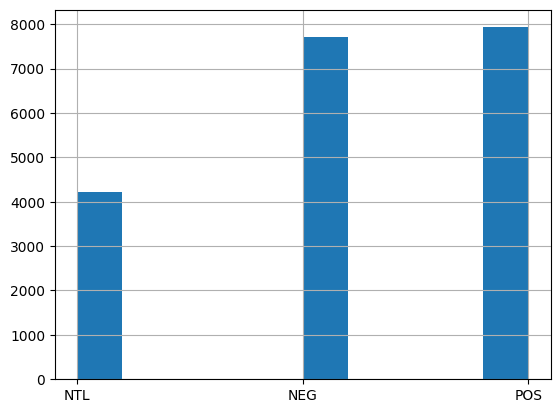

In [ ]:
normalized_data['label'].hist()

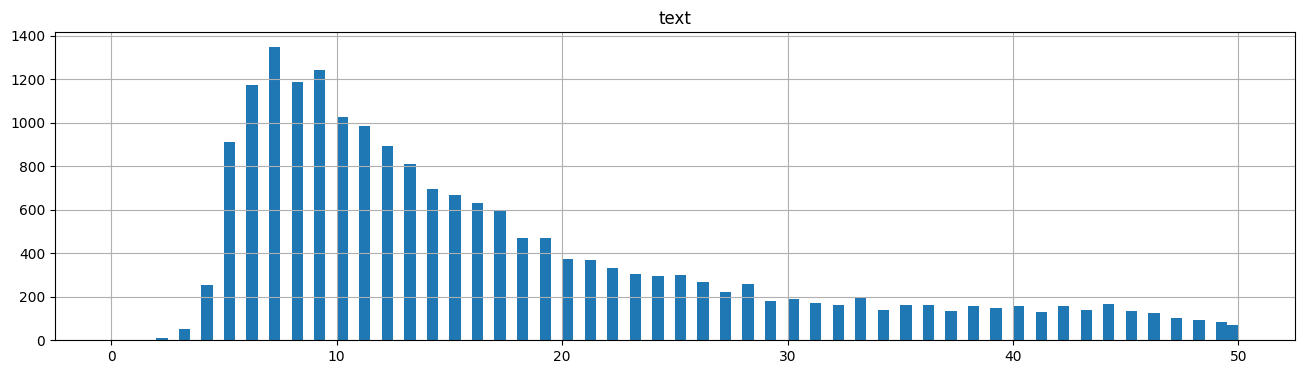

In [ ]:
text_count = [len(sentence.split()) for sentence in df.comment]

pd.DataFrame({'text': text_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [ ]:
vocab_size = 5000
embedding_dim = 300
max_len = 25

batch_size=128
epochs=30

tokenizer = Tokenizer(num_words=vocab_size, oov_token="", lower=True)
binarizer = LabelBinarizer()

In [ ]:
def simple_rnn():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(SimpleRNN(512, return_sequences=True))
    model.add(SimpleRNN(256))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics='accuracy')
    return model


In [ ]:
def gru():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(GRU(512, return_sequences=True))
    model.add(GRU(256))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics='accuracy')
    return model

In [ ]:
def bi_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics='accuracy')
    return model

In [ ]:
def conv1d():
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics='accuracy')
    return model

In [ ]:
# Plot history:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'], label='training data')
    plt.plot(history.history['val_loss'], label='validation data')
    plt.title('LOSS')
    plt.ylabel('Loss')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")

    # Plot history: Acc
    plt.figure()
    plt.plot(history.history['accuracy'], label='training data')
    plt.plot(history.history['val_accuracy'], label='validation data')
    plt.title('ACCURACY')
    plt.ylabel('Accuracy')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
def evaluate_model(trained_model, y_test_true):
    y_test_preds = trained_model.predict(x_test)
    y_test_preds = np.argmax(y_test_preds, axis=1)

    print(metrics.classification_report(y_test_true, y_test_preds))

    cm = metrics.confusion_matrix(y_test_true, y_test_preds, normalize='true')
    sns.heatmap(cm, annot=True, cbar=None, cmap='viridis')
    plt.show()
    f1 = metrics.f1_score(y_test_true, y_test_preds, average='macro')
    return f1

In [ ]:
data = pd.read_csv(norm_dataset)
data.label = data.label.map({'NEG':0, 'POS':2,'NTL':1})
data.head()

comment  label
0              we need mr chari 's review on master       1
1  worst government . #ysrcp chala cheta ga parip...      0
2  baya nuvu emina chepu kani bagoledu ani chepak...      0
3  gadini vadilesi manchi pani chesaru @rcbtweets üëç       2
4  i came to watch thyview 's review crying after...      2

In [ ]:
# stop words
stop_words = set(stopwords.words('english'))
#print(stop_words)
# removing words like no,not,didn`t..etc from stop words - (negations + contractions)
black_list = set(word for word in stop_words if 'no' in word or "'t" in word)

stop_words = stop_words - black_list
#print(stop_words)
data.comment = data.comment.apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]))


In [ ]:
labels = data.label.tolist()
sentences = data.comment.tolist()
_= tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
V = len(word_index)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
x_train, x_test, y_train, y_test = train_test_split(
    padded_sequences, labels, stratify=labels, test_size=0.1, random_state=101)

y_train_true = y_train.copy()
y_test_true = y_test.copy()


y_train = binarizer.fit_transform(y_train)
y_test = binarizer.fit_transform(y_test)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=101)
y_val_true = y_val.copy()
y_val = binarizer.fit_transform(y_val)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

x_train, y_train = smote.fit_resample(x_train, y_train)

Epoch 1/30
151/151 [==============================] - 50s 306ms/step - loss: 0.8807 - accuracy: 0.5918 - val_loss: 0.7115 - val_accuracy: 0.7021
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 48s 316ms/step - loss: 0.6347 - accuracy: 0.7401 - val_loss: 0.6222 - val_accuracy: 0.7490
Epoch 3/30
151/151 [==============================] - 47s 309ms/step - loss: 0.5249 - accuracy: 0.7906 - val_loss: 0.6574 - val_accuracy: 0.7339
Epoch 4/30
151/151 [==============================] - 54s 358ms/step - loss: 0.4283 - accuracy: 0.8367 - val_loss: 0.7116 - val_accuracy: 0.7306


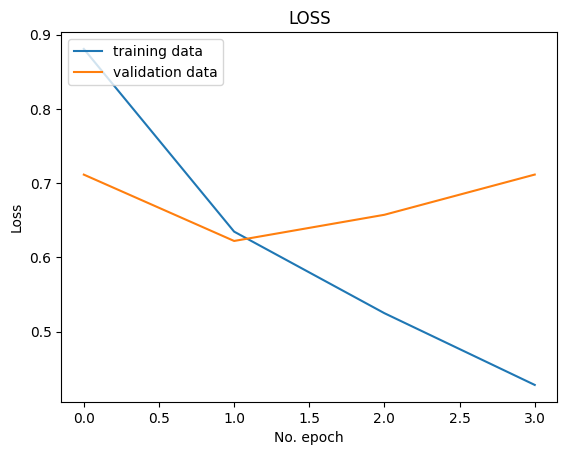

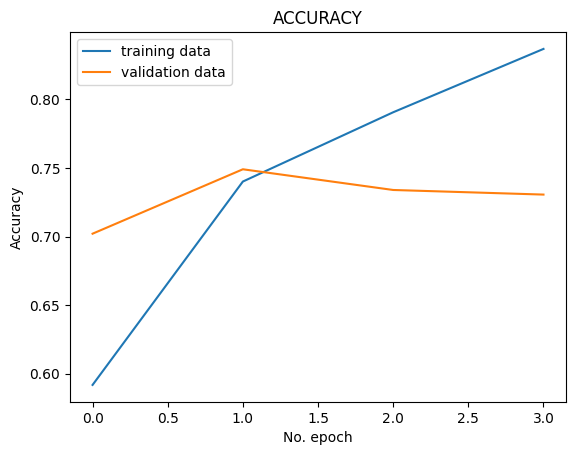

63/63 [==============================] - 2s 32ms/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       772
           1       0.46      0.69      0.55       422
           2       0.79      0.62      0.70       793

    accuracy                           0.69      1987
   macro avg       0.69      0.69      0.68      1987
weighted avg       0.73      0.69      0.70      1987



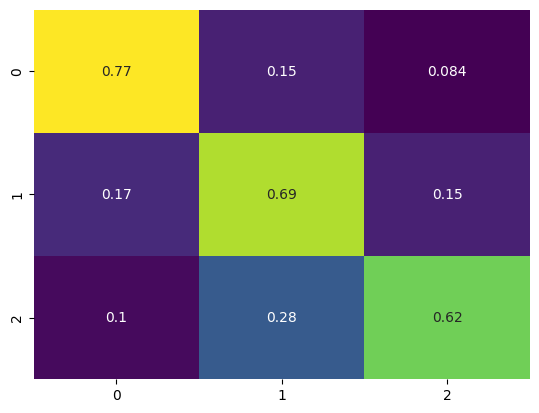

f1 score 0.6783394404934914


In [ ]:
# RNN
rnn_model = simple_rnn()
checkpoint_path="simple_rnn_model.h5"
keras_callbacks   = [
      EarlyStopping(monitor='accuracy', patience=3, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
history = rnn_model.fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=keras_callbacks)

plot_history(history)
f1 = evaluate_model(rnn_model, y_test_true)
print("f1 score", f1)

Epoch 1/30
151/151 [==============================] - 147s 938ms/step - loss: 0.9855 - accuracy: 0.4975 - val_loss: 0.9516 - val_accuracy: 0.5053
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 140s 928ms/step - loss: 0.8609 - accuracy: 0.5884 - val_loss: 0.8103 - val_accuracy: 0.5992
Epoch 3/30
151/151 [==============================] - 138s 915ms/step - loss: 0.7700 - accuracy: 0.6406 - val_loss: 0.6798 - val_accuracy: 0.7049
Epoch 4/30
151/151 [==============================] - 140s 927ms/step - loss: 0.6109 - accuracy: 0.7383 - val_loss: 0.5966 - val_accuracy: 0.7390


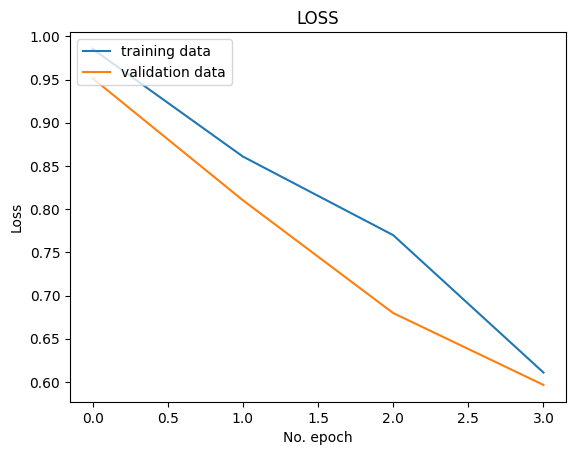

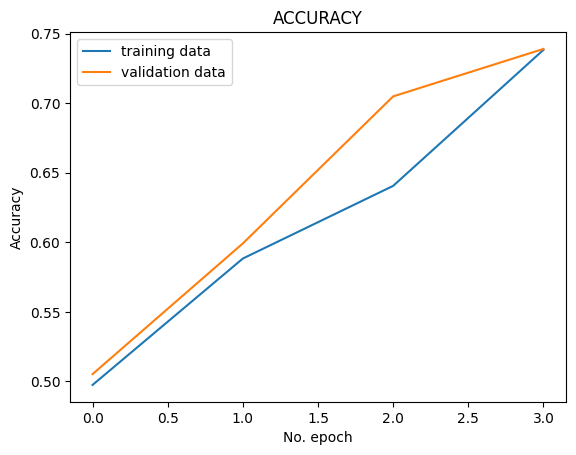

63/63 [==============================] - 8s 109ms/step
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       772
           1       0.47      0.78      0.59       422
           2       0.82      0.62      0.71       793

    accuracy                           0.72      1987
   macro avg       0.72      0.73      0.71      1987
weighted avg       0.77      0.72      0.73      1987



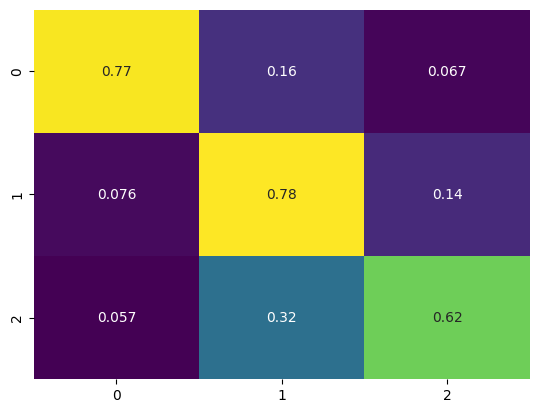

f1 score 0.7059542582580093


In [ ]:
# GRU
gru_model = gru()
checkpoint_path="gru_model.h5"
keras_callbacks   = [
      EarlyStopping(monitor='accuracy', patience=3, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
history = gru_model.fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=keras_callbacks)

plot_history(history)
f1 = evaluate_model(gru_model, y_test_true)
print("f1 score", f1)

In [ ]:
# layers = keras.layers

Epoch 1/30
151/151 [==============================] - 500s 3s/step - loss: 0.9264 - accuracy: 0.5540 - val_loss: 0.8872 - val_accuracy: 0.5752
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 482s 3s/step - loss: 0.6410 - accuracy: 0.7328 - val_loss: 0.6200 - val_accuracy: 0.7398
Epoch 3/30
151/151 [==============================] - 494s 3s/step - loss: 0.5265 - accuracy: 0.7879 - val_loss: 0.6000 - val_accuracy: 0.7433
Epoch 4/30
151/151 [==============================] - 502s 3s/step - loss: 0.4774 - accuracy: 0.8125 - val_loss: 0.6101 - val_accuracy: 0.7474
Epoch 5/30
151/151 [==============================] - 514s 3s/step - loss: 0.4374 - accuracy: 0.8295 - val_loss: 0.7016 - val_accuracy: 0.7232
Epoch 6/30
151/151 [==============================] - 500s 3s/step - loss: 0.4054 - accuracy: 0.8462 - val_loss: 0.6764 - val_accuracy: 0.7433


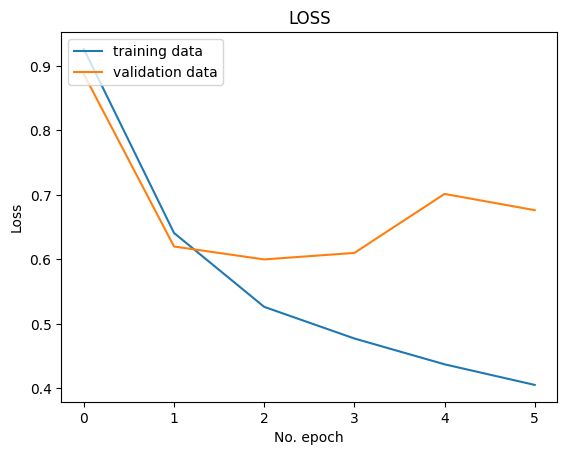

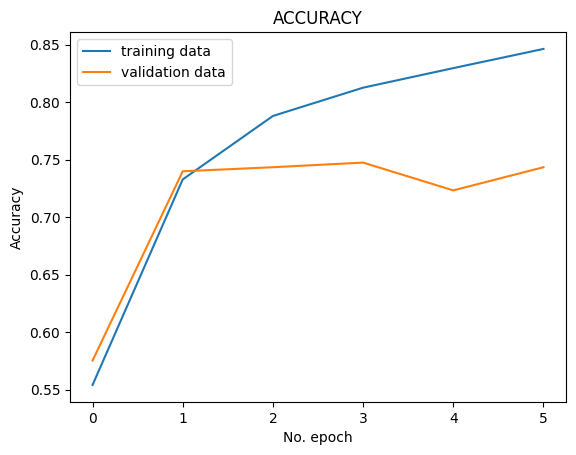

63/63 [==============================] - 20s 294ms/step
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       772
           1       0.53      0.67      0.60       422
           2       0.78      0.76      0.77       793

    accuracy                           0.74      1987
   macro avg       0.73      0.73      0.73      1987
weighted avg       0.76      0.74      0.75      1987



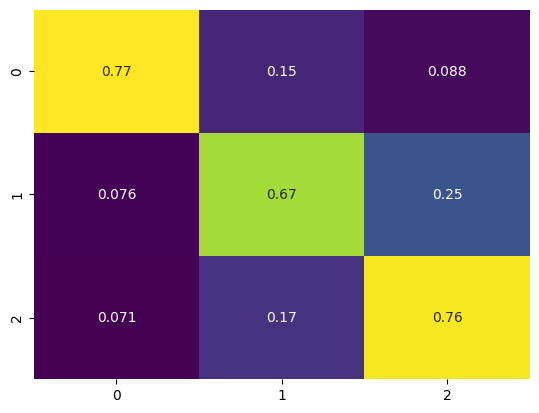

f1 score 0.7257887347334288


In [ ]:
# BI LSTM

bi_lstm_model = bi_lstm()
checkpoint_path="bi_lstm_model.h5"
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
history = bi_lstm_model.fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=keras_callbacks)

plot_history(history)
f1 = evaluate_model(bi_lstm_model, y_test_true)
print("f1 score", f1)


Epoch 1/30
151/151 [==============================] - 21s 129ms/step - loss: 0.9885 - accuracy: 0.5188 - val_loss: 0.9635 - val_accuracy: 0.5003
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 19s 124ms/step - loss: 0.8886 - accuracy: 0.5863 - val_loss: 0.8581 - val_accuracy: 0.6130
Epoch 3/30
151/151 [==============================] - 19s 126ms/step - loss: 0.6588 - accuracy: 0.7282 - val_loss: 0.6084 - val_accuracy: 0.7287
Epoch 4/30
151/151 [==============================] - 20s 132ms/step - loss: 0.5175 - accuracy: 0.7940 - val_loss: 0.5964 - val_accuracy: 0.7499
Epoch 5/30
151/151 [==============================] - 19s 124ms/step - loss: 0.4423 - accuracy: 0.8290 - val_loss: 0.6381 - val_accuracy: 0.7363
Epoch 6/30
151/151 [==============================] - 19s 124ms/step - loss: 0.3810 - accuracy: 0.8577 - val_loss: 0.6430 - val_accuracy: 0.7353
Epoch 7/30
151/151 [==============================] - 20s 133ms/step - loss: 0.3258 - accuracy: 0.8833 - val_loss: 0.6972 - val_accuracy: 0.7433


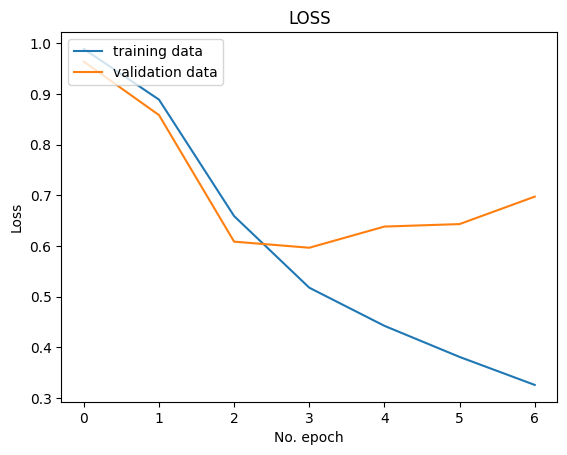

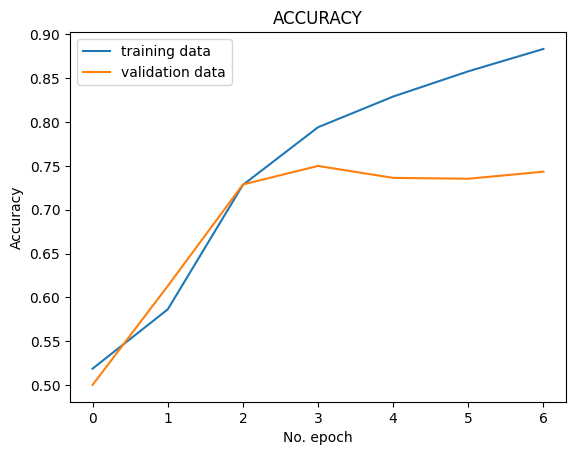

63/63 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       772
           1       0.53      0.74      0.62       422
           2       0.80      0.74      0.77       793

    accuracy                           0.74      1987
   macro avg       0.73      0.74      0.73      1987
weighted avg       0.77      0.74      0.75      1987



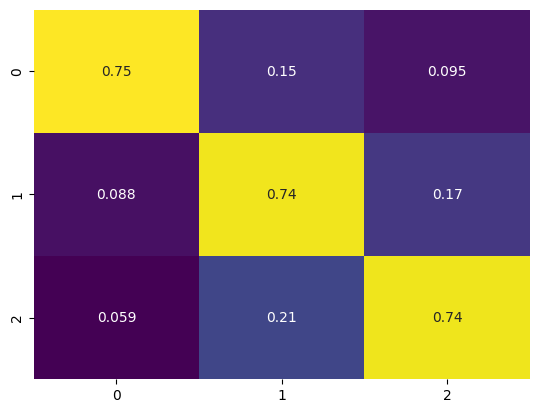

f1 score 0.7303131452766203


In [ ]:
conv_model = conv1d()
checkpoint_path="conv_model.h5"
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
history = conv_model.fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=keras_callbacks)

plot_history(history)
f1 = evaluate_model(conv_model, y_test_true)
print("f1 score", f1)

BERT

In [ ]:
data = pd.read_csv(norm_dataset)

In [ ]:
data.shape

(19868, 2)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from tensorflow.keras.utils import to_categorical

from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
from numpy import array
from numpy import asarray
from numpy import zeros


In [ ]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
!pip install --upgrade simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
y=data['label'].tolist()
X_train, X_test, y_train, y_test = train_test_split(data['comment'].tolist(), y, random_state=5, test_size=0.2) #train, test split
#validation split
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                 classes=np.unique(y_train),
                                              y=y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=5, test_size=0.1)


In [ ]:
list_of_class={'NEG':0,'NTL':1,'POS':2}
y_val=[list_of_class[i.strip()]for i in y_val]
y_train=[list_of_class[i.strip()]for i in y_train]
y_test=[list_of_class[i.strip()]for i in y_test]

In [ ]:
# class weights
class_weights

array([0.85714286, 1.57070857, 0.83564669])

In [ ]:
d1 = {'comment': X_train, 'label': y_train}
df_train = pd.DataFrame(d1)

In [ ]:
d2 = {'comment': X_val, 'label': y_val}
df_val = pd.DataFrame(d2)

In [ ]:
d3 = {'comment': X_test, 'label': y_test}
df_test = pd.DataFrame(d3)

In [ ]:
df_train.shape,df_val.shape,df_test.shape

((14304, 2), (1590, 2), (3974, 2))

In [ ]:
model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs': 3, 'weights': [0.85714286, 1.57070857, 0.83564669]})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
model.train_model(df_train)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1788 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1788 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1788 [00:00<?, ?it/s]

(5364, 0.5325983603395338)

In [ ]:
comments = df_test['comment'].tolist()
predictions, raw_outputs = model.predict(comments)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
list_of_class={0:'NEG',1:'NTL',2:'POS'}
print(classification_report([list_of_class[i] for i in y_test],
                            [list_of_class[i] for i in predictions]))

              precision    recall  f1-score   support

         NEG       0.87      0.82      0.84      1536
         NTL       0.59      0.70      0.64       849
         POS       0.84      0.79      0.82      1589

    accuracy                           0.79      3974
   macro avg       0.77      0.77      0.77      3974
weighted avg       0.80      0.79      0.79      3974



In [ ]:
cnf_matrix = confusion_matrix([list_of_class[i] for i in y_test],
                              [list_of_class[i] for i in predictions])


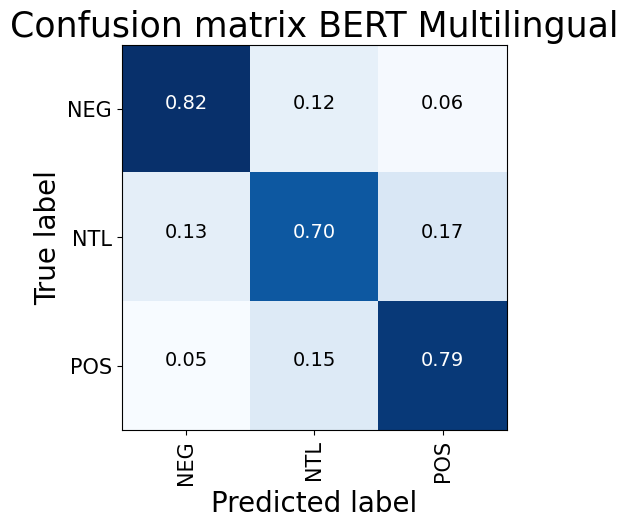

In [ ]:
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=list(list_of_class.values()), title="Confusion matrix BERT Multilingual")
plt.show()

In [ ]:
# making predictions on new data
predictions = model.predict(["nvu anthaga bagooooledhu","nvu chala bagunnav","vadu enti chetthat ga unnadu"])
print(predictions)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([0, 2, 0]), array([[ 1.82910156, -0.38232422, -1.15820312],
       [-2.25585938, -1.92480469,  4.2421875 ],
       [ 3.0546875 , -1.23925781, -1.56835938]]))
